# Topic Modeling and Recommending Similar Stories

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

random_state=42 # to make sure its reproducible

from glob import glob
datafiles = glob('data/*')

In [24]:
# packages for preprocessing text
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords

# packages for topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
# loading the data
stories_data = pd.read_csv(datafiles[0])

## Cleaning the column names to make it easier to work with

In [26]:
# dropping duplicates if the text are the same
stories_data.drop_duplicates(subset=['Story texts'], inplace=True)

# renaming columns to make them easier to work with
drop_columns = [column for column in stories_data.columns if 'link' in column.lower()]
drop_columns.extend([ 'Title', 'Lede', 'Cringey', 'Haha', 'Me too', 'Interesting', 'Phone', 'Like'])
stories_data.drop(columns=drop_columns, inplace=True, errors='ignore')

stories_data.columns = [column.lower().replace(' ', '_') for column in stories_data.columns]
stories_data.rename(columns={
    'id':'story_id'
}, inplace=True)
stories_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2014 entries, 0 to 2060
Data columns (total 8 columns):
story_id        2014 non-null int64
perspective     2014 non-null object
age             1548 non-null float64
lgbtq           1548 non-null object
race            1548 non-null object
topic           2014 non-null object
published_at    819 non-null object
story_texts     2013 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 141.6+ KB


In [27]:
# how many are missing data
stories_data.isna().sum()

story_id           0
perspective        0
age              466
lgbtq            466
race             466
topic              0
published_at    1195
story_texts        1
dtype: int64

In [28]:
# dropping the row that doenst have data for the text column since we're using the text column heavily
stories_data.dropna(subset=['story_texts'], inplace=True)

# resetting index since i dropped rows earlier
stories_data.reset_index(inplace=True)
stories_data.drop('index', axis=1, inplace=True)

## Cleaning the Text

1. lemmatizing the text
2. removing stop words
4. create n_grams
3. vectorizing the words to feed to the algorithm

In [29]:
stories_data['cleaned'] = stories_data.story_texts.str.replace('[^\w\s]','')

# getting the POS tags to feed to the lem
stories_data['pos_tagged'] = stories_data.cleaned.map(word_tokenize).map(pos_tag)

In [30]:
lem = WordNetLemmatizer()
stories_data['lemmed'] = stories_data['pos_tagged'].map(lambda x: [lem.lemmatize(word, tag[0].lower()) for word, tag in x if tag[0].lower() in ['a', 'v', 'r', 'n']])
stories_data.lemmed = stories_data.lemmed.map(lambda x: ' '.join(word for word in x))

## Topic Modeling with different algorithms

In [31]:
# transforming the stop words in the same pattern that the text is being processed as 
stop_words = stopwords.words('english')
stop_words = [s.translate(str.maketrans('', '', string.punctuation)) for s in stop_words]

# additional stop words removing from corpus
additional_stop_words = ['im', 'idk', 'friend', 'nothing', 'meh'
                         , 'ha', 'hey', 'hi', 'ive', 'vjfjfjfc', 'umm']

In [32]:
#tfidf vectorizer
tfidf = TfidfVectorizer(stop_words=stop_words + additional_stop_words
                        , lowercase=True
                       , ngram_range=(1,2))

# document term matrix 
tfidf_dtm = tfidf.fit_transform(stories_data.lemmed)

In [33]:
# tfidf_nmf.components_ # an array like a dictionary with words and values aka the h component matrix lol 

In [34]:
def display_topics(model, feature_names, no_top_words=10, topic_names=None):
    for index, topic in enumerate(model.components_):
        if not topic_names or not topic_names[index]:
            print("\nTopic ", index)
        else:
            print("\nTopic: '",topic_names[index],"'")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])) # reversed

In [35]:
n_components=9
tfidf_nmf = NMF(n_components=n_components
            , random_state=random_state)
tfidf_nmf_data = tfidf_nmf.fit_transform(tfidf_dtm)

In [36]:
# note to self: it seems like stop words are removed before n grams are created
# need to check source code to make sure
# i wonder if you can modifer the sihoette score for topic modeling

display_topics(tfidf_nmf, tfidf.get_feature_names())


Topic  0
tell, say, want, go, school, mom, tell tell, come, day, anyone

Topic  1
sex, sex sex, want, want sex, boyfriend, sex want, sex say, sexy, bad, keyon

Topic  2
good, good girl, room good, room, girl good, good act, dick, hello, home good, good guy

Topic  3
get, period, go, start, puberty, get period, mom, go puberty, hair, bathroom

Topic  4
make, feel, felt, people, make feel, really, well, think, look, way

Topic  5
know, know know, want, want know, know feel, know relationship, know say, feel, bye, really know

Topic  6
ask, say, consent, ask consent, yes, fuck, say yes, boyfriend, question, ask say

Topic  7
girl, like, like girl, girl school, gender, boy, dress, question, good girl, act

Topic  8
date, talk, like, love, guy, start, break, relationship, want, still


In [37]:
m, n = tfidf_nmf_data.shape
tfidf_nmf_df = pd.DataFrame(tfidf_nmf_data, columns=[f'topic_{num}' for num in range(n)])
tfidf_nmf_df['max_topic'] = tfidf_nmf_data.argmax(axis=1)
tfidf_nmf_df['max_topic'].value_counts().sort_values()

2     74
1     95
5    144
7    154
6    224
0    224
8    327
3    328
4    443
Name: max_topic, dtype: int64

In [38]:
combined = pd.merge(stories_data, tfidf_nmf_df, left_index=True, right_index=True)

## Figuring out what the topics actually mean by looking at the stories

sorting the stories by the highest ranking to figure out what the topics mean

In [39]:
display_topics(tfidf_nmf, tfidf.get_feature_names())


Topic  0
tell, say, want, go, school, mom, tell tell, come, day, anyone

Topic  1
sex, sex sex, want, want sex, boyfriend, sex want, sex say, sexy, bad, keyon

Topic  2
good, good girl, room good, room, girl good, good act, dick, hello, home good, good guy

Topic  3
get, period, go, start, puberty, get period, mom, go puberty, hair, bathroom

Topic  4
make, feel, felt, people, make feel, really, well, think, look, way

Topic  5
know, know know, want, want know, know feel, know relationship, know say, feel, bye, really know

Topic  6
ask, say, consent, ask consent, yes, fuck, say yes, boyfriend, question, ask say

Topic  7
girl, like, like girl, girl school, gender, boy, dress, question, good girl, act

Topic  8
date, talk, like, love, guy, start, break, relationship, want, still


In [40]:
# dictionary to map the topics numbers and the defined topic names
topics = {}
combined.sort_values(by='topic_0', ascending=False).head()['story_texts'].tolist()

["I was really close with this boy and he was like my best friend; Then one day he told me he liked me and I didn't like him back; So I didn't know how to tell him so I told one of my other friends to tell him; Now we are not close anymore",
 'My friendship was ruined because of a boy. I told my best friend that this boy is not right for you but you can still like him.. I just gave her my opinion. ; A week later he told me to tell my best friend that he doesn’t like her. I tried to tell my best friend that he doesn’t like her and she just blocked me out. I should’ve not been in there business but I was.; I kept texting telling her that I’m sorry and I want to be BEST FRIENDS again. She says yes every single time.; But in the next day of school she blocks me out again. She told me "I just want to be friends". I told her that I can’t be just friends after all she did to me. ; I told her about how many times she hurt my feeling called me fat, told me my pants were ugly and more. So I hurt

In [41]:
topics['topic_0'] = 'interpersonal_relationships_conversations' # venting and advice

combined.sort_values(by='topic_1', ascending=False).head()['story_texts'].tolist()

['I will sex; 0; 0; 0',
 'Me ; Sex ; Sex; Sex',
 'Can we have sex; I want to have sex; I love sex; About sex; Good ; No body ',
 'Sex; Sex; Sex; Sex; Sex',
 'Idk; Because sex is fun and good; How big is your 🍆; Sex; Good; Keyon']

In [42]:
topics['topic_1'] = 'the word sex'
combined.sort_values(by='topic_2', ascending=False).head()['story_texts'].tolist()

['Because ; 17; Idk; Good ',
 'Hey; Who is this; Who is this; My ass; Good ; 💍',
 'Idk; Idk; Idk; Idk; Idk; Good',
 'I was 7 ; nothing; good; a girl ; umm',
 'My room; 😂😂; Good ']

In [43]:
topics['topic_2'] = 'app_confusion'
combined.sort_values(by='topic_3', ascending=False).head()['story_texts'].tolist()

["I first realized I was going through puberty when I started getting acne, at first I thought it was going to go away in a few weeks and I didn't care to wash my face because I didn't think to much of it.; I was about ten years old at the time, which was 5th grade for me. We were starting to watch puberty videos and learning about our health more around that time.; I could tell I was going through puberty because I had to get new bras and I started buying razors for the future and I was going through major mood swings. Pubic hair was starting to grow and my acne was getting worse.; I felt nervous, I didn't know when it would happen and I really didn't want to, but at the same time all my friends were bragging how they got their periods while I had still been waiting, which made me impatient. ",
 "When I first got my period, I thought I was bleeding because something was wrong; But it turned out to be my period; My first official period started on the last day of school when I was in 6

In [44]:
topics['topic_3'] = 'puberty' # first period
combined.sort_values(by='topic_4', ascending=False).head()['story_texts'].tolist()

['I was attracted to someone that I gotten the opportunity to know and after awhile of us being friends I realized that what I felt for them was bigger than what we were.; I think what I found myself attracted to most was the fact that they listened to me. They didn’t belittle how I felt or tell me I was being stupid for question things. They were patient and understanding, and the fact that they genuinely cared made me feel like I was worth something; even if it was just to them.; I never felt physical attraction to them. That always confused me at first, and I wasn’t sure if that was because I didn’t actually like them more than a friend or if I was just attracted to the characteristics that make them who they are; minus their physical appearance. Then, I researched and researched and found out that I’m asexual and the lack of sexual or physical attraction to them made sense.; People started to notice how I acted around them before they did. They would drop subtle hints or make jokes

In [45]:
topics['topic_4'] = 'feeling_judged' # social relationships
combined.sort_values(by='topic_5', ascending=False).head()['story_texts'].tolist()

["No; 12; I don't know ; Good 🌟 😍🌞",
 'Why ; ???; I don’t know ; No; I don’t know ',
 'I don’t know ; I don’t know ; I don’t know ; I don’t know ',
 'I don’t know ; I don’t know ; I don’t know ; I would say I’m a female ; Girl',
 'Hi; Who are you; Good; Well don’t know; Stop why do u want to know?']

In [46]:
topics['topic_5'] = 'i_dont_know'
combined.sort_values(by='topic_6', ascending=False).head()['story_texts'].tolist()

['How old are you; 13; Why are you asking!; Idk',
 'I didn’t, I didn’t even do anything; Nothing; I didn’t ask for consent; They said yes.; Confused. Because I didn’t ask for consent.; I didn’t ask for consent. I don’t even know what I am asking consent for.',
 'So I had a huge crush on my (now) boyfriend I asked him out as a dare but he said no at first but we got closer and he asked me out 🙂; What; So I had a huge crush on my (now) boyfriend.I asked him out at first he said no.but we got closer and he asked me out.; He said no but then he asked me out; Happy; Really suppressed ',
 'My girlfriend was the one asking for consent ; She asked if we were ok to kiss ; She got her friend to ask me ; I got a bonner and said it was ok ; We kissed in the end ; I felt happy and got a huge boner ',
 'my best friend asked me for consent; i am currently in the closet as bisexual so she asked me for consent to talk to our friend group about me being queer; she texted me saying that my friend group t

In [47]:
topics['topic_6'] = 'consent_and_sex'
combined.sort_values(by='topic_7', ascending=False).head()['story_texts'].tolist()

["Hi; Girl ; I'm ok x; How old are ix; U",
 '9; Because I liked this girl in my school ; Ok; I’m straight ; Like a girl ',
 'I was born a girl man ; Nothing I was born a girl man; I am a girl ; I am a girl and I was born a girl use your noggin ayy ; I am a girl and I dress like a girl thank you next',
 "I questioned my gender identity at 11. i was born a girl some times I wish I was a boy but I'm a girl😔; What made me question my gender was that being a girl is harder then being a boy. Theres so much girlS have to do that boys don't       ; I felt mad and depressed I hated life and I still hate It  ; I identify as a girl. I was born a girl I'm still a girl now ; I don't know what I look like or dress or act",
 '26; I.... i..... likes basketball 🥴; Good because I am a girl and I feel like it and I always have been.🤗; Girl. DURH; Nothing I am a girl']

In [48]:
topics['topic_7'] = 'being_a_girl'
combined.sort_values(by='topic_8', ascending=False).head()['story_texts'].tolist()

["So I had this boyfriend. I started dating him in October and he broke up with me in may. I was kinda fine with it like we were falling out; So then in October of the next year we started doing cross country together again and he started regretting breaking up with me; So then he was talking to my best friend about how he liked me and he kept trying to FaceTime me; And then he started dating my enemy who is my best friend's other best friend; And I like his best friend and he found out some how. But the guy I like doesn’t even know me but damnnnnn he’s so hot.",
 'So I really like this guy and he really likes me, but he wants to date me and I’m not ready.; But I’m not sure if it’s because I’m not ready or if it’s because my best friend who also likes this guy isn’t ready; She never likes talking about him, and is jealous, but she’s such a good friend; I just don’t know if I should date him, or listen to my bestie and just be his friend',
 "So I had this boyfriend. I started dating him

In [49]:
topics['topic_8'] = 'dating_and_relationships'

# renaming the columns to make more intuitive sense 
combined.rename(columns=topics, inplace=True)

## Recommending similar stories based on their topic modeling scores

Now that we have different features to compare the stories along different dimensions, can we generate recommendations based on how similar stories are to each other?

In [50]:
cosine_scores = cosine_similarity(tfidf_nmf_data, tfidf_nmf_data)

# have to get the second most similar since the most similar would be with itself and we dont want that lol
combined['most_similar_index'] = cosine_scores.argsort()[:, -2] 
# combined.head()

In [51]:
# wow a self join have the most similar story in the same row to make it easier to compare
self_joined = pd.merge(combined, combined['story_texts'], left_on='most_similar_index', right_index=True)

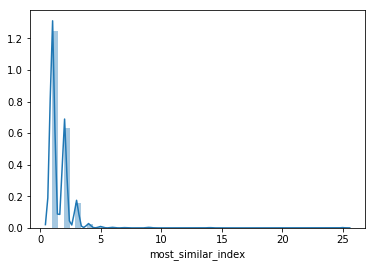

In [52]:
# there are a few stories that are deemed to be most similar to lots of other stories
sns.distplot(combined.most_similar_index.value_counts());

In [53]:
random_sample = self_joined[~self_joined.published_at.isna()].sample(n=10
                   , random_state=random_state)
random_sample

,story_id,perspective,age,lgbtq,race,topic,published_at,story_texts_x,cleaned,pos_tagged,...,app_confusion,puberty,feeling_judged,i_dont_know,consent_and_sex,being_a_girl,dating_and_relationships,max_topic,most_similar_index,story_texts_y
139,2123,female,19.0,no,latinx,bullying,2020-02-10 00:00:00 UTC,The person that judged me was a girl that I di...,The person that judged me was a girl that I di...,"[(The, DT), (person, NN), (that, WDT), (judged...",...,0.000000,0.000000,0.110474,0.000000,0.033840,0.033476,0.000000,4,801,My fiend was spreading rumors about me being l...
1082,1021,female,18.0,yes,black,relationships,2019-09-14 00:00:00 UTC,I came out to my mom; If I get married I want ...,I came out to my mom If I get married I want h...,"[(I, PRP), (came, VBD), (out, RB), (to, TO), (...",...,0.001791,0.045776,0.007663,0.004353,0.028407,0.000000,0.021749,3,461,I was walking on the streets with my mom; When...
1963,57,other,NaN,NaN,NaN,relationships,2017-09-30 00:00:00 UTC,My best friend is a pansexual gender fluid and...,My best friend is a pansexual gender fluid and...,"[(My, PRP$), (best, JJS), (friend, NN), (is, V...",...,0.002544,0.000000,0.043333,0.067388,0.009000,0.003101,0.053182,5,1794,I feel like I'm falling in love with my best f...
1033,1072,female,13.0,no,white,relationships,2019-03-03 00:00:00 UTC,Omg so this one guy I was talking to on Snapch...,Omg so this one guy I was talking to on Snapch...,"[(Omg, NNP), (so, RB), (this, DT), (one, CD), ...",...,0.000000,0.003277,0.015797,0.000000,0.104116,0.000000,0.042309,6,1829,My ex-boyfriend never actually asked me out; I...
1700,322,female,NaN,NaN,NaN,relationships,2019-09-30 00:00:00 UTC,Ok..... so literally this guy is PERFECT; We w...,Ok so literally this guy is PERFECT We went on...,"[(Ok, NNP), (so, RB), (literally, RB), (this, ...",...,0.000663,0.000000,0.000000,0.025119,0.000000,0.000000,0.073542,8,1715,I had a thing with this guy and so did my frie...
1735,287,female,NaN,NaN,NaN,puberty,2019-03-06 00:00:00 UTC,I turn 14 in march and I still haven't started...,I turn 14 in march and I still havent started ...,"[(I, PRP), (turn, VBP), (14, CD), (in, IN), (m...",...,0.000000,0.081647,0.000000,0.000000,0.000000,0.000000,0.027400,3,1636,I hate having pubic hair sm!; When I touch my ...
1577,445,female,NaN,NaN,NaN,puberty,2019-09-11 00:00:00 UTC,When I started puberty I felt sooo awkward lik...,When I started puberty I felt sooo awkward lik...,"[(When, WRB), (I, PRP), (started, VBD), (puber...",...,0.000009,0.066827,0.037579,0.000000,0.000000,0.000000,0.018402,3,1840,Every time I go to the gymnasium we do fun thi...
1889,131,female,NaN,NaN,NaN,relationships,2018-11-24 00:00:00 UTC,I once liked a girl that was really pretty and...,I once liked a girl that was really pretty and...,"[(I, PRP), (once, RB), (liked, VBD), (a, DT), ...",...,0.000000,0.000000,0.021960,0.000000,0.000000,0.095166,0.062605,7,1962,Disney is fake; I watched twilight and I thot ...
314,1911,female,19.0,no,black,bullying,2020-02-13 00:00:00 UTC,They didn’t say it to my face but when we were...,They didnt say it to my face but when we were ...,"[(They, PRP), (didnt, VBP), (say, VBP), (it, P...",...,0.000000,0.045956,0.019579,0.000000,0.011504,0.000600,0.000000,3,1468,I first realised when i was nine is that bad I...
1423,641,female,14.0,no,white,relationships,2019-10-14 00:00:00 UTC,I liked a boy as a friend but he liked me more...,I liked a boy as a friend but he liked me more...,"[(I, PRP), (liked, VBD), (a, DT), (boy, NN), (...",...,0.000000,0.010161,0.029219,0.000000,0.050864,0.020845,0.055105,8,325,my ex boyfriend ; for physical contact and cud...


In [54]:
# checking a recommended story
random_sample[['story_texts_x', 'story_texts_y']].head(1).values

array([['The person that judged me was a girl that I didn’t know very well at the time. ; I was going to recruitment of joining a sorority and we were having a conversation.; The questions I was being asked were not completely indicative of who I am as a person but rather of superficial aspects. ; We weren’t connecting about many things so it felt that she was looking down on me for being different. ; I felt sad and embarrased. ; It made me feel better to remind myself that being different is a good thing. ',
        'My fiend was spreading rumors about me being lesbian; The fact that she said it in such a way made me feel derogatory ; They thought I was weird ; I felt upset and betrayed ; Later they said it was a joke and shut the rumors down; She was one of my best friends, still is']],
      dtype=object)

## Are there patterns with these topics?

In [ ]:
# correlation with different topics in the docs
sns.pairplot(data=tfidf_nmf_df)

There seems to be some correlation between topic 7 with topic 2, and topic 2 with topic 8. It would be interesting to see why

In [ ]:
sns.catplot(x='crushes_on_guys', y='perspective', kind='box', data=combined)

In [ ]:
sns.catplot(x='crushes_on_guys', y='topic', kind='box', data=combined) 
# proves that there are better ways to categorize stories

In [ ]:
sns.catplot(x='crushes_on_guys', y='lgbtq', kind='box', data=combined) 

In [ ]:
# are kids talking about sex more than any other topic?
# i dont think scatter plot is the best way to visualize this interaction....
sns.scatterplot(x='age', y='sex', data=combined[combined.age<100]) # removed the obvious bad answers

In [ ]:
sns.scatterplot(x='age', y='female_sexuality', data=combined[combined.age<100])

In [ ]:
topics.values()

In [ ]:
sns.scatterplot(x='age', y='social_situations_at_school', data=combined[combined.age<100])

In [ ]:
sns.scatterplot(x='age', y='puberty_first_period', data=combined[combined.age<100])

In [ ]:
sns.scatterplot(x='age', y='crushes_on_guys', data=combined[combined.age<100])

In [ ]:
combined.info()

In [ ]:
sns.boxplot(combined.age)

In [ ]:
combined.iloc[0]

In [ ]:
combined.iloc[156]

In [ ]:
combined.iloc[2012]

In [ ]:
combined.iloc[1577]

In [ ]:
combined.shape

In [ ]:
combined.iloc[0]

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2
            , verbose=1
            , perplexity=500
            , n_iter=400
            , random_state=random_state)

In [ ]:
tfidf_tsne_data = tsne.fit_transform(tfidf_nmf_data)

In [ ]:
plt.rcParams.update({'figure.figsize': (10, 10)})
sns.scatterplot(tfidf_tsne_data[:, 0], tfidf_tsne_data[:, 1],
                size = 2, palette = 'coolwarm', alpha = 'auto', 
               markers = '.')

In [ ]:
feature_columns = tfidf_nmf_weights.columns

In [ ]:
plt.rcParams.update({'figure.figsize': (10, 120)})
for i in range(len(feature_columns)):
    plt.subplot(len(feature_columns), 1, i+1)
    sns.scatterplot(tfidf_tsne_data[:, 0], tfidf_tsne_data[:, 1]
                    ,hue=tfidf_nmf_weights[feature_columns[i]]
                , size = 2, palette = 'coolwarm', alpha = 'auto', 
               markers = '.')
    plt.title(f'Feature: {feature_columns[i]}');

## it would be interesting to know the distribution of topics and the relationship with the predetermined topics from myhealthed

## How many clusters can i find to see if this works for topic modeling

In [ ]:
from sklearn.decomposition import SparsePCA, TruncatedSVD

from sklearn.utils.extmath import randomized_svd

# U, Sigma, VT = randomized_svd

In [ ]:
# need to reduce the dimensions
random_state=42
svd = TruncatedSVD(random_state=random_state, n_components=2)

In [ ]:
svd_results = svd.fit_transform(X=tfidf_dtm)

In [ ]:
svd_results

In [ ]:
len(svd_results)

In [ ]:
stories_data[['svd_component_1', 'svd_component_2']] =pd.DataFrame(svd_results)

stories_data.head()

In [ ]:
sns.scatterplot(data=stories_data
                , x=stories_data.svd_component_1, y=stories_data.svd_component_2, hue='topic')

## what if we try to reduce the dimensions and cluster and compare the centroids to identify themes in the clusters as a way of topic modeling? 

so far im not getting a lot of progress with topic modeling so i want to try something different

In [ ]:
tfidf_dtm.shape # over 18k parameters that i need to reduce

In [ ]:
svd = TruncatedSVD(n_components=5000 # this is still a lot of parameters to fit a model....
                , random_state=random_state)

svd_fitted = svd.fit_transform(tfidf_dtm)

In [ ]:
np.cumsum(svd.explained_variance_ratio_)

In [ ]:
plt.plot(np.cumsum(svd.explained_variance_ratio_)) # i want to achieve 
# this can be used to find the elbow of the plot to find the optimal number of components

In [ ]:
tfidf_dtm.shape

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.cumsum(svd.explained_variance_ratio_))

In [ ]:
svd.explained_variance_ratio_.sum()

In [ ]:
print(len(np.cumsum(svd.explained_variance_ratio_)))

In [ ]:
svd.components_.

In [ ]:
svd.explained_variance_ratio_